<img src="https://github.com/FarzadNekouee/Heart_Disease_Prediction/blob/master/image.jpg?raw=true" width="1800">

In this notebook, we explore a dataset containing various health metrics from heart patients, such as age, blood pressure, heart rate, and more. Our objective is to develop a predictive model that can accurately identify individuals with heart disease.

# Step 0: Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix



# Default model function 
def Default (model):
    model.fit(X_train,y_train)
    model_Preds = model.predict(X_test)
    plot_confusion_matrix(model,X_test,y_test)
    print(classification_report(y_test,model_Preds))
    
    

# Tuning hyperparameter function
def Tuning (model, param_grid, scoring='recall', n_splits=3):
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid.fit(X_train, y_train)
    
    # Get the best estimator
    best_grid = grid.best_estimator_
    
    # Get the prediction
    train_grid_Preds = best_grid.predict(X_train)
    test_grid_Preds = best_grid.predict(X_test)
    
    # Print the best hyperparmeters
    print ('best_hyperparameters: \n', grid.best_params_)
    
    # Plot an print the report for prediction of training and testing
    print('\n Evaulation of training data : \n',classification_report(y_train,train_grid_Preds))
    print ('\n ************************************ \n ')
    print('Evaulation of testing data: \n',classification_report(y_test,test_grid_Preds))
    print ('\n ************************************ \n ')
    
    plot_confusion_matrix(best_grid,X_test,y_test)
    

# Step 1: Read data

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Step 2: Data overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


According to the data description, we can see that there are some categeriocal features have a numerical data types so we should convert the data tyeps for better analysis and interpretation.

In [4]:
Con_features = ['age','trestbps','chol','thalach','oldpeak']   # Continuos features 
Cat_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal','target']    # Categeorical features
df[Cat_features] = df[Cat_features].astype('object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    object 
dtypes: float64(1), int64(4), object(9)
memory usage: 33.3+ KB


In [6]:
df.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [7]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,2,0,2,1
freq,207,143,258,152,204,142,175,166,165


#### For the target: the common class is (1) indicating the presence of heart disease, And we want to explore the data So in this step  we aim to gain insights into the individual characteristics of the data and also how each feature relates to our main goal: predicting the target variable.

# Step 3: EDA

The avg of age is:  54.366336633663366
The std of age is:  9.082100989837858


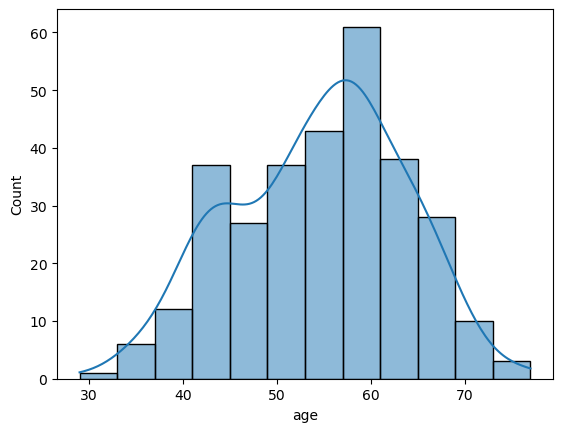

The avg of trestbps is:  131.62376237623764
The std of trestbps is:  17.53814281351709


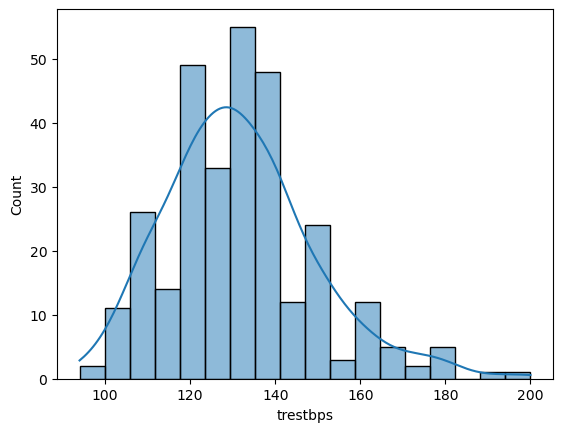

The avg of chol is:  246.26402640264027
The std of chol is:  51.830750987930045


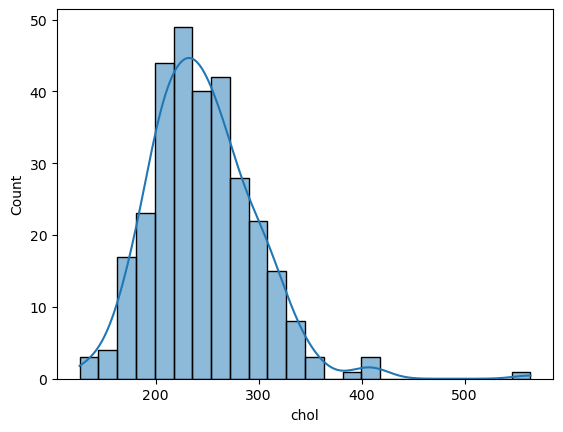

The avg of thalach is:  149.64686468646866
The std of thalach is:  22.905161114914087


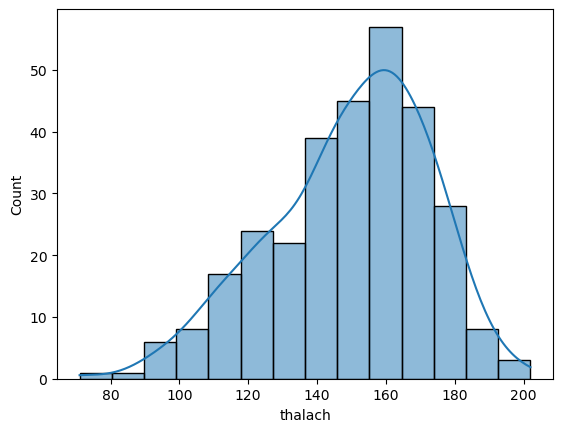

The avg of oldpeak is:  1.0396039603960396
The std of oldpeak is:  1.1610750220686343


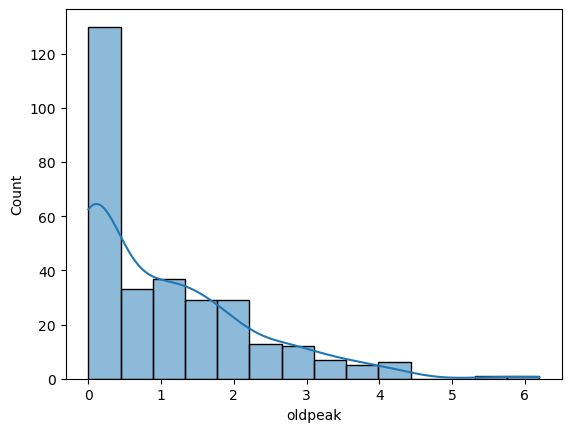

In [8]:
# plotting the distribution for the continuos features 
for feature in Con_features:
    print(f'The avg of {feature} is: ',df[feature].mean())
    print(f'The std of {feature} is: ',df[feature].std())
    plt.figure()
    sns.histplot(data=df, x=feature,kde=True)
    plt.show()

Percentage of each class in sex:
  1: 68.32%
  0: 31.68%


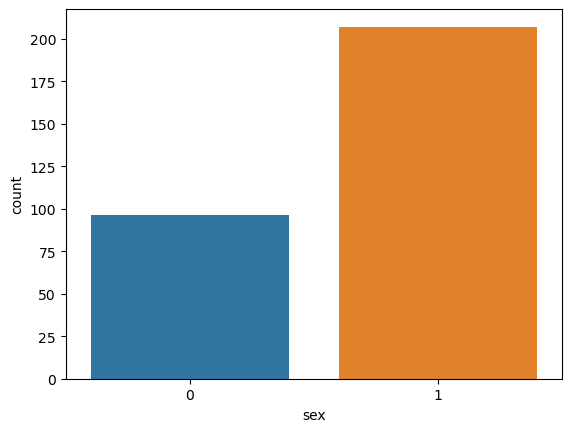

Percentage of each class in cp:
  0: 47.19%
  2: 28.71%
  1: 16.50%
  3: 7.59%


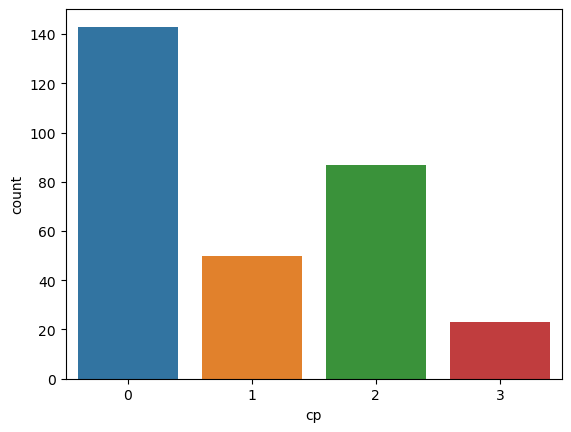

Percentage of each class in fbs:
  0: 85.15%
  1: 14.85%


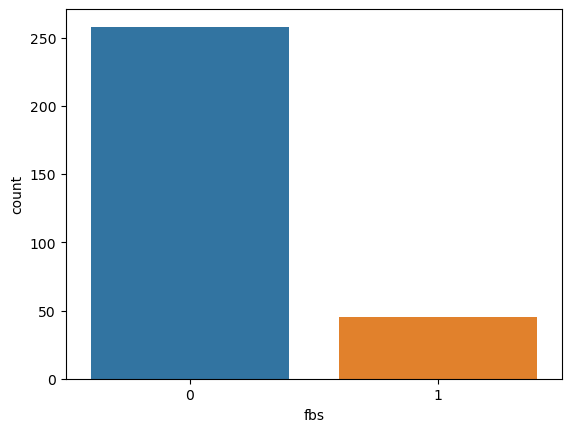

Percentage of each class in restecg:
  1: 50.17%
  0: 48.51%
  2: 1.32%


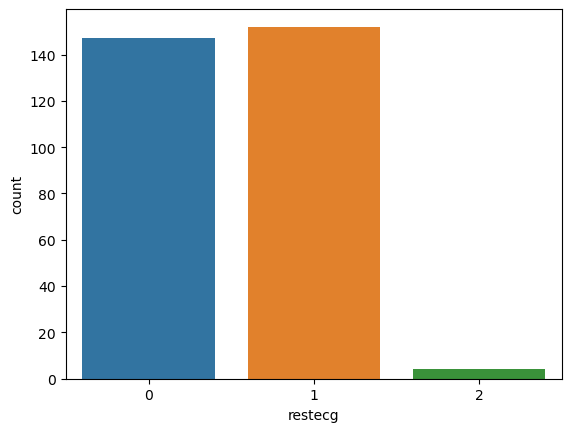

Percentage of each class in exang:
  0: 67.33%
  1: 32.67%


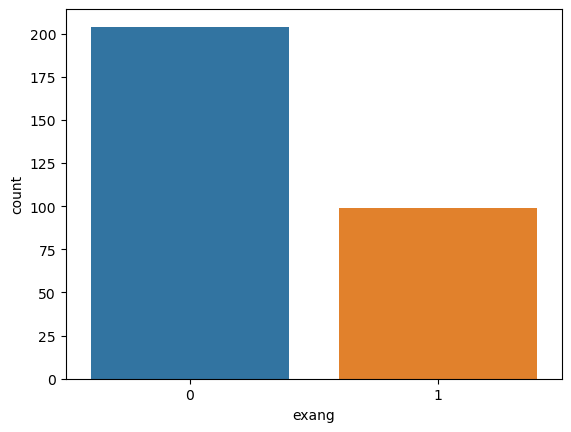

Percentage of each class in slope:
  2: 46.86%
  1: 46.20%
  0: 6.93%


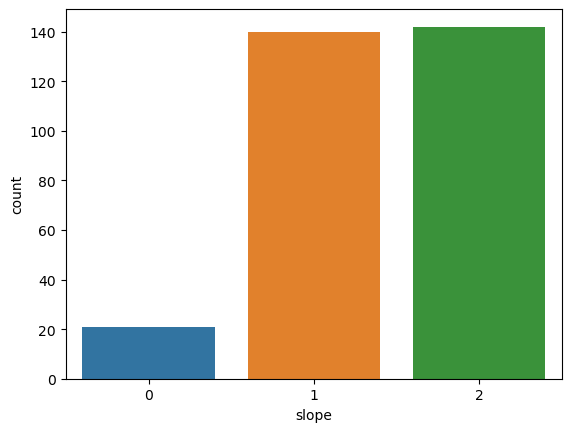

Percentage of each class in ca:
  0: 57.76%
  1: 21.45%
  2: 12.54%
  3: 6.60%
  4: 1.65%


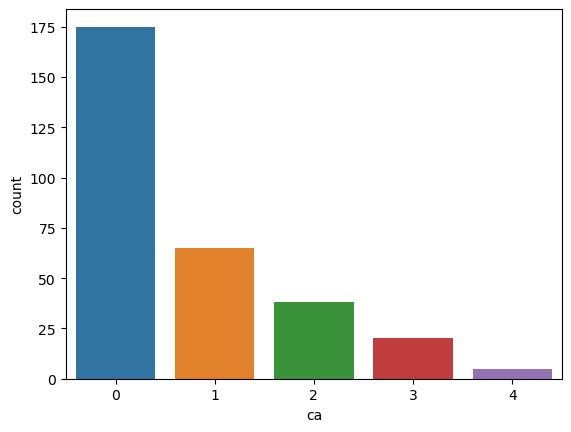

Percentage of each class in thal:
  2: 54.79%
  3: 38.61%
  1: 5.94%
  0: 0.66%


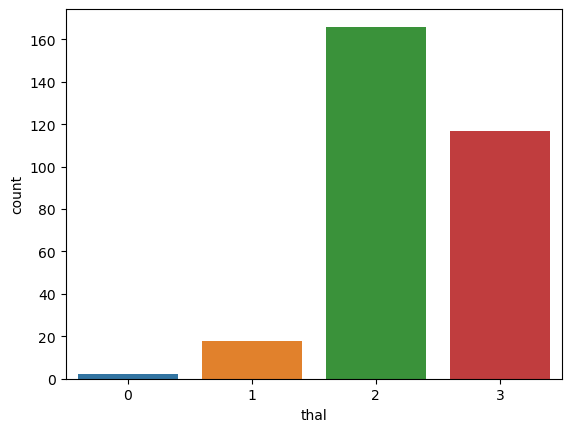

Percentage of each class in target:
  1: 54.46%
  0: 45.54%


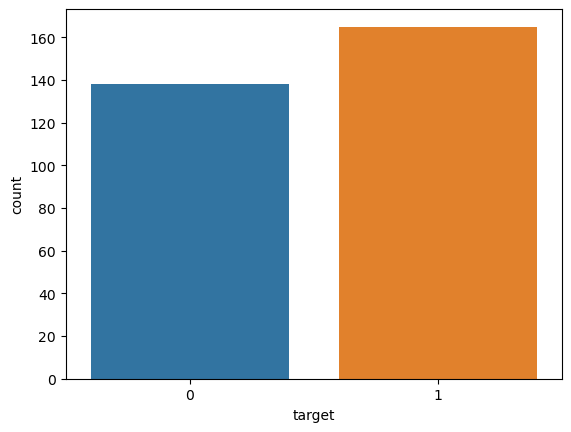

In [9]:
for feature in Cat_features:
    
    class_counts = df[feature].value_counts(normalize=True) * 100
    
    print(f"Percentage of each class in {feature}:")
    for class_value, percentage in class_counts.items():
        print(f"  {class_value}: {percentage:.2f}%")
    
    plt.figure()
    sns.countplot(data=df, x=feature)
    plt.show()

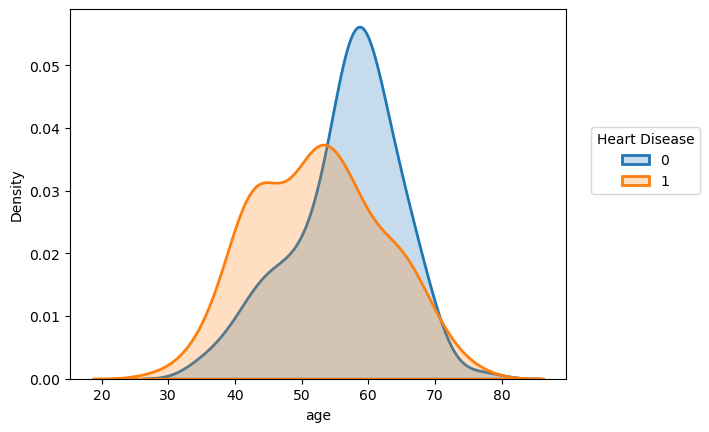

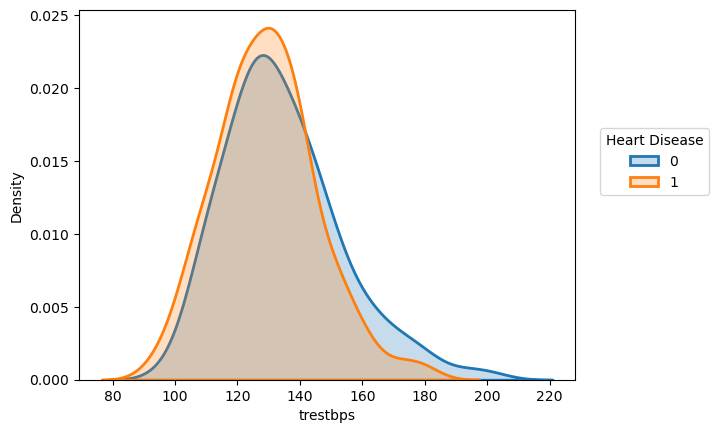

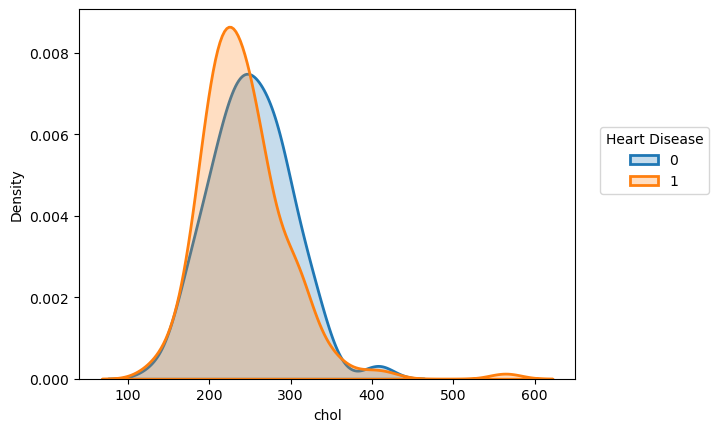

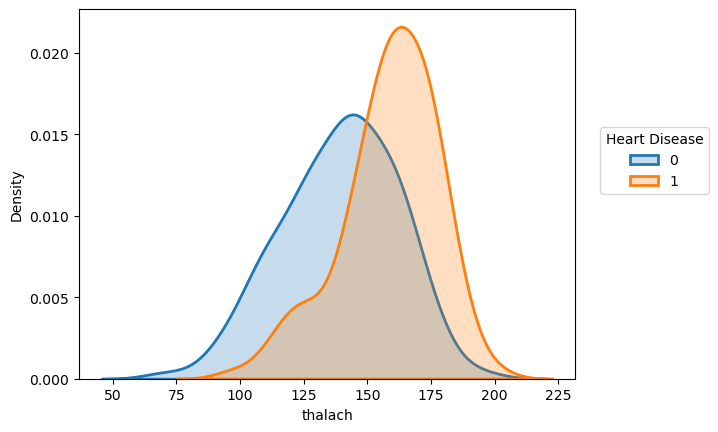

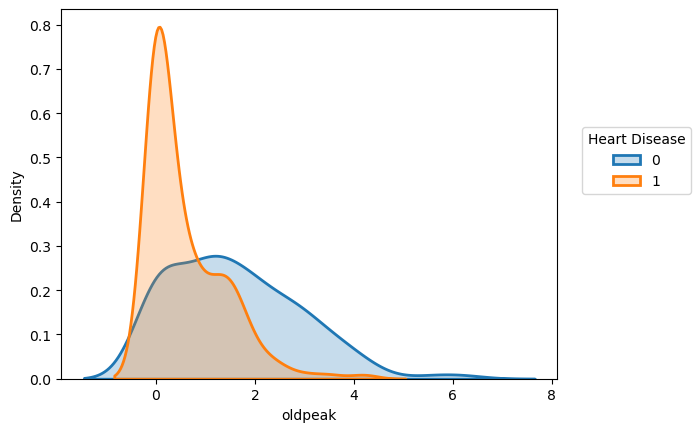

In [10]:
# Plot the relation between Con features and the target column
for feature in Con_features:
    plt.figure()
    sns.kdeplot(data=df[df["target"]==0], x=feature, fill=True, linewidth=2, label='0')
    sns.kdeplot(data=df[df["target"]==1], x=feature, fill=True, linewidth=2, label='1')
    plt.legend(loc=(1.05,0.5),title='Heart Disease')
    plt.show()

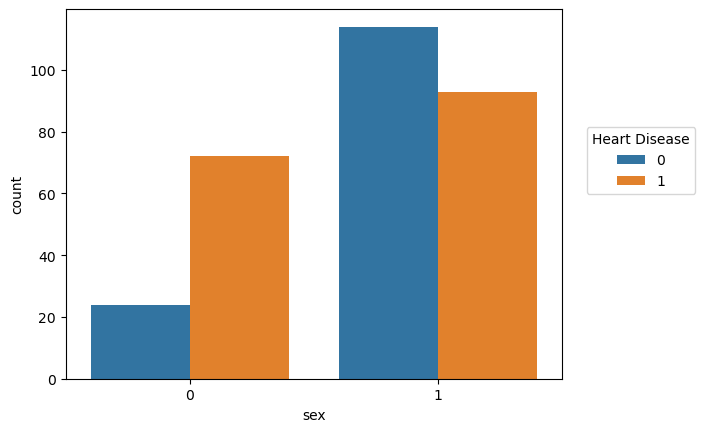

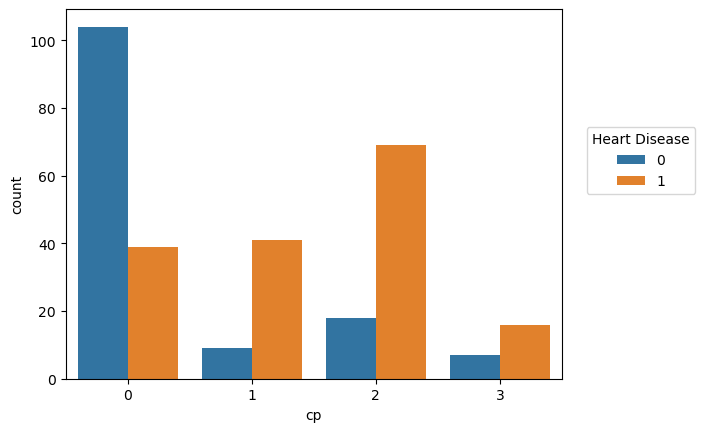

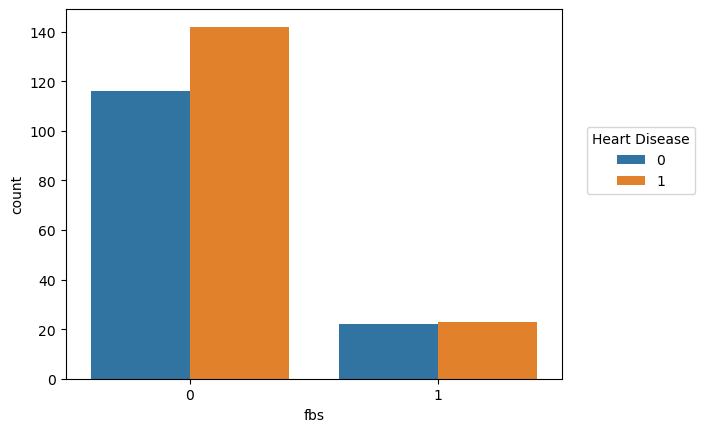

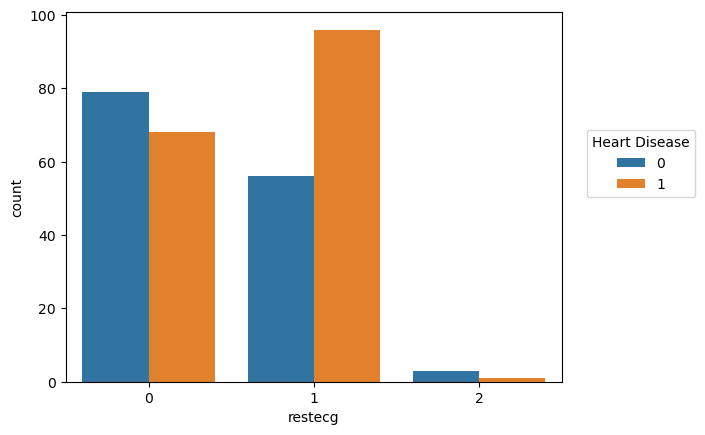

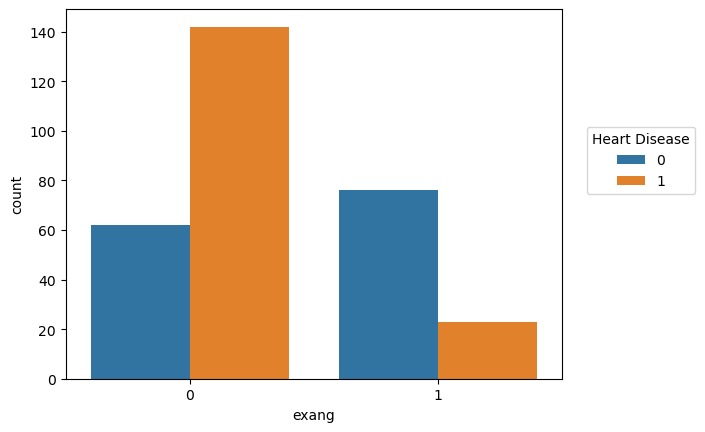

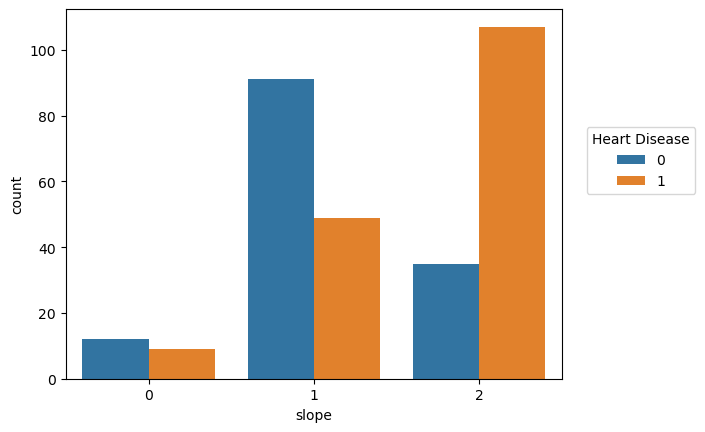

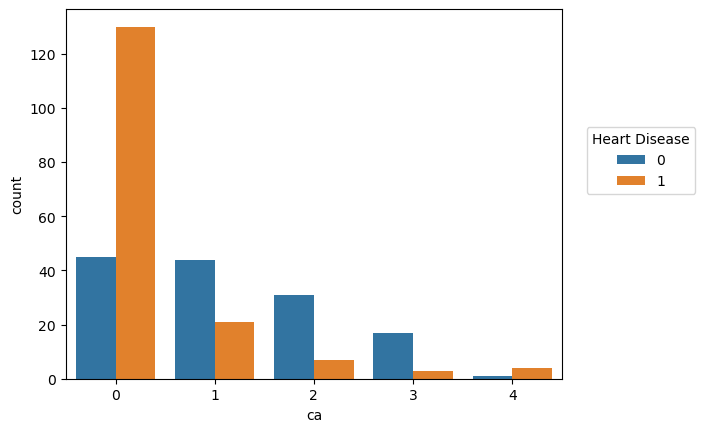

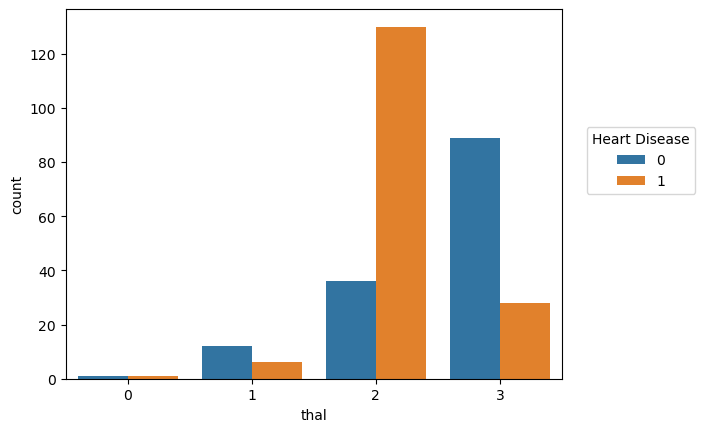

In [11]:
# Check the distrbution according to target 
for feature in Cat_features[:-1]:
    
    plt.figure()
    sns.countplot(data=df, x=feature,hue='target')
    plt.legend(loc=(1.05,0.5),title='Heart Disease')
    plt.show()

# Step 4: Data Preprocessing

In [12]:
# Check if there is any null values
df.isnull().sum().max()

0

In [13]:
# Check the outlies using IQR
Q1 = df[Con_features].quantile(0.25)
Q3 = df[Con_features].quantile(0.75)
IQR = Q3 - Q1
IQR

age         13.5
trestbps    20.0
chol        63.5
thalach     32.5
oldpeak      1.6
dtype: float64

In [14]:
Outilers = ((df[Con_features] < (Q1 - 1.5 * IQR)) | (df[Con_features] > (Q3 + 1.5 * IQR))).sum()
Outilers
# Can be neglectd 

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    object 
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    object 
dtypes: float64(1), int64(4), object(9)
memory usage: 33.3+ KB


### From data description we notice that Only three nominal and need en encoded process 

In [16]:
df = pd.get_dummies(df,columns=['cp','restecg','thal'],drop_first=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    int64  
 1   sex        303 non-null    object 
 2   trestbps   303 non-null    int64  
 3   chol       303 non-null    int64  
 4   fbs        303 non-null    object 
 5   thalach    303 non-null    int64  
 6   exang      303 non-null    object 
 7   oldpeak    303 non-null    float64
 8   slope      303 non-null    object 
 9   ca         303 non-null    object 
 10  target     303 non-null    object 
 11  cp_1       303 non-null    uint8  
 12  cp_2       303 non-null    uint8  
 13  cp_3       303 non-null    uint8  
 14  restecg_1  303 non-null    uint8  
 15  restecg_2  303 non-null    uint8  
 16  thal_1     303 non-null    uint8  
 17  thal_2     303 non-null    uint8  
 18  thal_3     303 non-null    uint8  
dtypes: float64(1), int64(4), object(6), uint8(8)
memor

### The remain five features can be converted into integers as there contain 0,1 or there is an ordinal relationship

In [18]:
df[['sex','fbs','exang','slope','ca','target']] = df[['sex','fbs','exang','slope','ca','target']].astype(int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    int64  
 1   sex        303 non-null    int32  
 2   trestbps   303 non-null    int64  
 3   chol       303 non-null    int64  
 4   fbs        303 non-null    int32  
 5   thalach    303 non-null    int64  
 6   exang      303 non-null    int32  
 7   oldpeak    303 non-null    float64
 8   slope      303 non-null    int32  
 9   ca         303 non-null    int32  
 10  target     303 non-null    int32  
 11  cp_1       303 non-null    uint8  
 12  cp_2       303 non-null    uint8  
 13  cp_3       303 non-null    uint8  
 14  restecg_1  303 non-null    uint8  
 15  restecg_2  303 non-null    uint8  
 16  thal_1     303 non-null    uint8  
 17  thal_2     303 non-null    uint8  
 18  thal_3     303 non-null    uint8  
dtypes: float64(1), int32(6), int64(4), uint8(8)
memory

# Step 5: Models

### Note: In medical scenarios, especially in the context of diagnosing illnesses, it's often more important to have a high recall (sensitivity) for the positive class (patients with the condition).

In [20]:
# Splitting data
X = df.drop(columns='target')
y = df['target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Decision Tree

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        31
           1       0.76      0.93      0.84        30

    accuracy                           0.82        61
   macro avg       0.84      0.82      0.82        61
weighted avg       0.84      0.82      0.82        61



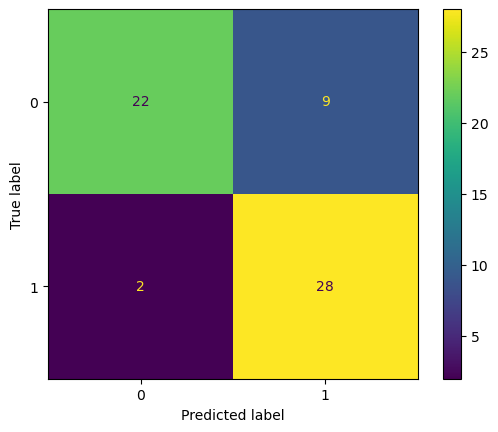

In [22]:
DT = DecisionTreeClassifier()

Default(DT)

best_hyperparameters: 
 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       107
           1       0.91      0.94      0.92       135

    accuracy                           0.91       242
   macro avg       0.91      0.91      0.91       242
weighted avg       0.91      0.91      0.91       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.79      0.90      0.84        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


 ************************************ 
 


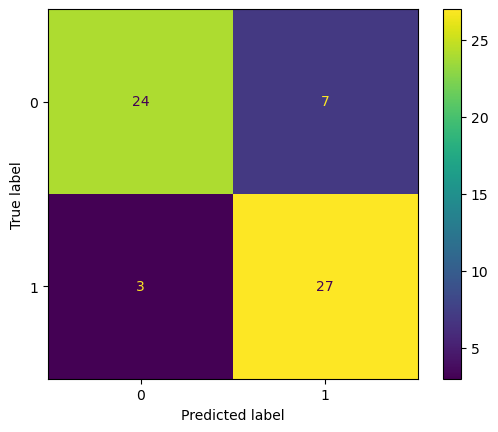

In [23]:
param_grid_dt = {
   'criterion': ['gini','entropy'],
    'max_depth': [3,4,5],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3,4] 
}

Tuning(DT,param_grid_dt)

### Random forest

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.82      0.93      0.87        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



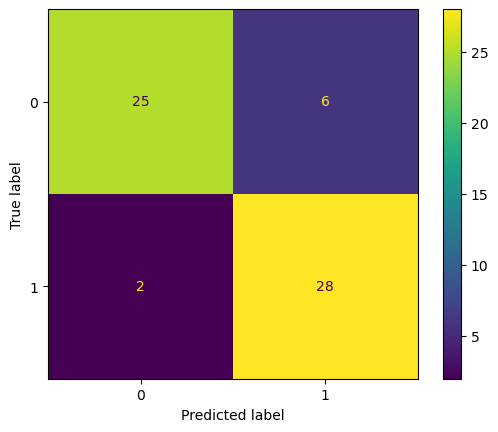

In [24]:
RF = RandomForestClassifier()
Default(RF)

best_hyperparameters: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       107
           1       0.85      0.87      0.86       135

    accuracy                           0.84       242
   macro avg       0.84      0.84      0.84       242
weighted avg       0.84      0.84      0.84       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        31
           1       0.84      0.87      0.85        30

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


 ************************************ 
 


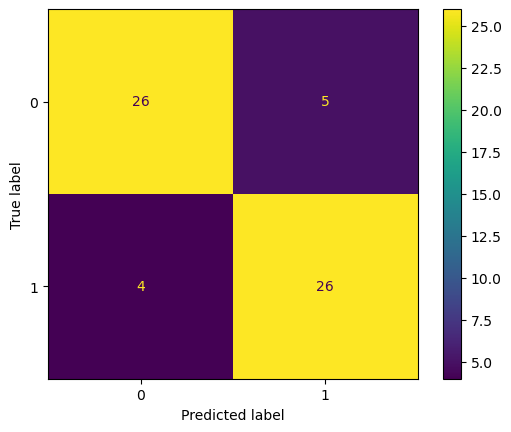

In [25]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

Tuning(RF,param_grid_rf)

### Adabosting

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.82      0.93      0.87        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



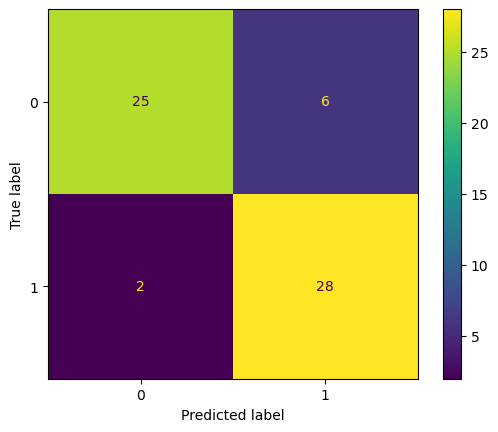

In [26]:
ADA = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
Default(ADA)

best_hyperparameters: 
 {'base_estimator__max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 150}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       107
           1       0.86      0.90      0.88       135

    accuracy                           0.86       242
   macro avg       0.86      0.86      0.86       242
weighted avg       0.86      0.86      0.86       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        31
           1       0.81      0.87      0.84        30

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61


 ************************************ 
 


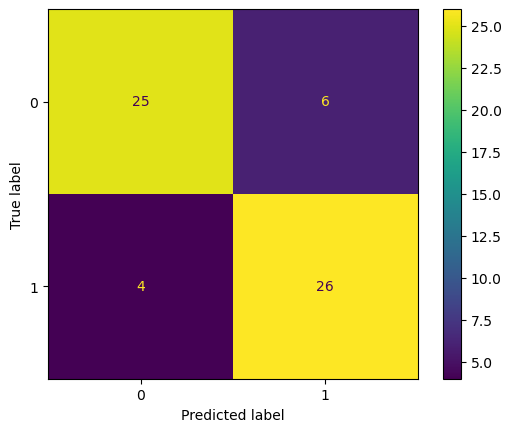

In [27]:
param_grid_ada = {
   'n_estimators': [50,100,150,200],
    'learning_rate': [0.01, 0.1, 1.0, 10.0],
    'base_estimator__max_depth': [1, 2, 3]
}

Tuning(ADA,param_grid_ada)

### Gradient boosting

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.80      0.93      0.86        30

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



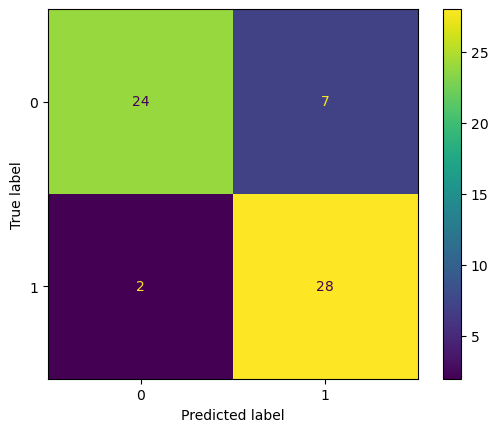

In [28]:
Grad = GradientBoostingClassifier()
Default(Grad)

best_hyperparameters: 
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       107
           1       0.84      0.95      0.89       135

    accuracy                           0.87       242
   macro avg       0.88      0.86      0.86       242
weighted avg       0.87      0.87      0.87       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       0.96      0.74      0.84        31
           1       0.78      0.97      0.87        30

    accuracy                           0.85        61
   macro avg       0.87      0.85      0.85        61
weighted avg       0.87      0.85      0.85        61


 ************************************ 
 


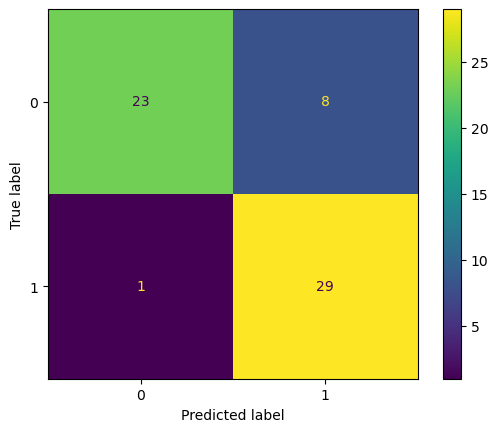

In [29]:
param_grid_grad = {
    'n_estimators': [50, 100,200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
}

Tuning(Grad,param_grid_grad)

### SVC

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        31
           1       0.82      0.90      0.86        30

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



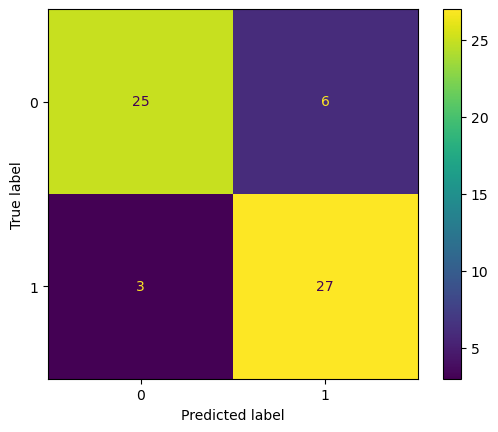

In [30]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

Default(svm_pipeline)

best_hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.96      0.48      0.64       107
           1       0.70      0.99      0.82       135

    accuracy                           0.76       242
   macro avg       0.83      0.73      0.73       242
weighted avg       0.82      0.76      0.74       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       1.00      0.52      0.68        31
           1       0.67      1.00      0.80        30

    accuracy                           0.75        61
   macro avg       0.83      0.76      0.74        61
weighted avg       0.84      0.75      0.74        61


 ************************************ 
 


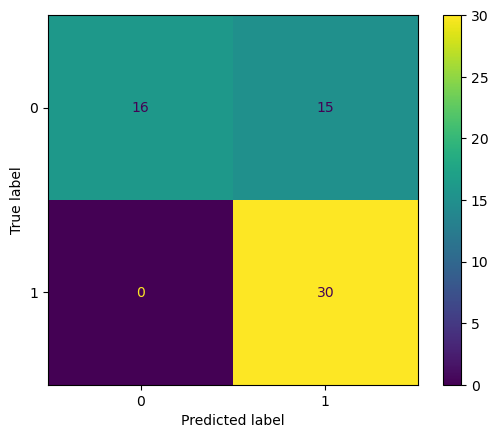

In [31]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

Tuning(svm_pipeline,param_grid_svm)

### XGboost

              precision    recall  f1-score   support

           0       0.96      0.81      0.88        31
           1       0.83      0.97      0.89        30

    accuracy                           0.89        61
   macro avg       0.90      0.89      0.88        61
weighted avg       0.90      0.89      0.88        61



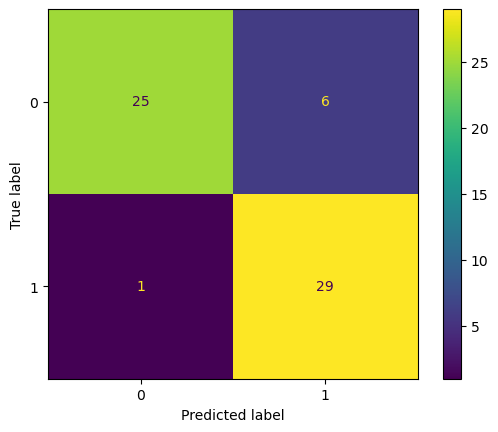

In [32]:
XGB = xgboost.XGBClassifier()
Default(XGB)

best_hyperparameters: 
 {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10.0}

 Evaulation of training data : 
               precision    recall  f1-score   support

           0       0.89      0.79      0.84       107
           1       0.84      0.93      0.88       135

    accuracy                           0.86       242
   macro avg       0.87      0.86      0.86       242
weighted avg       0.87      0.86      0.86       242


 ************************************ 
 
Evaulation of testing data: 
               precision    recall  f1-score   support

           0       0.96      0.77      0.86        31
           1       0.81      0.97      0.88        30

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


 ************************************ 
 


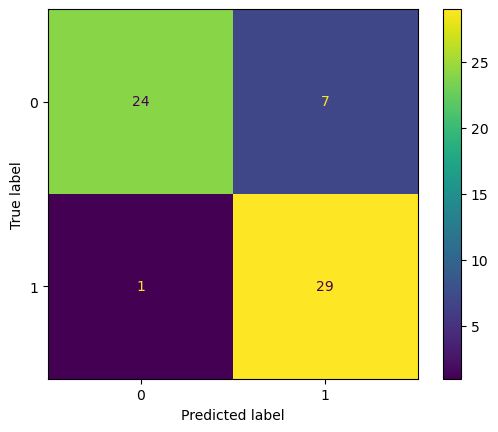

In [33]:
#XGBoosting optimization
param_grid_xgb ={
     'max_depth':[3,4,5],
     'learning_rate':[0.1,0.01,0.05],
     'gamma':[0.0,0.25,1],
     'reg_lambda':[0.0,1.0,10.0]
}

Tuning(XGB,param_grid_xgb)

# Step 6: Conclusion

The SVM model demonstrates a commendable capability in recognizing potential heart patients. With a recall of 100% for class 1, it's evident that all patients with heart disease are correctly identified. This is of paramount importance in a medical setting. But, the model is making a lot of False Positive predictions and making the recall for class 0 low.
Although the preforance for other model like XGB and Gradient doing well as the recall is 0.97 so there is a tradeoff between getting all patients correctly letting a lot of FP or allow some FNs but avoiding this extreme FPs errors 